## Multivariate Time Series forecast using seq2seq in TensorFlow

This notebook implements the details of applying seq2seq model for Time Series case study. The purpose is to show the effectiveness of seq2seq to learn the true patterns under the noisy signals. In addition, we are able to implement models with flexibility such as: 

- Variable input and output sequence lengths
- Variable numbers of input and output signals 

This tutorial is divided into three parts - first we will be demonstrating how to train a seq2seq model on univariate data. The model is then easily applied to multivariate cases. 

To see the comprehensive explanations of each step, can jump to the post associated with this study - 
weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

# Univariate time series

In [1079]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy



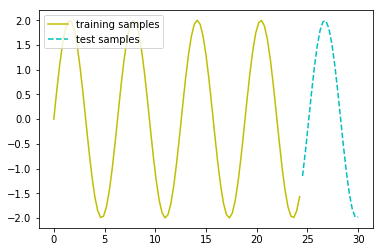

In [1080]:
x = np.linspace(0, 30, 105)
y = 2 * np.sin(x)

l1, = plt.plot(x[:85], y[:85], 'y', label = 'training samples')
l2, = plt.plot(x[85:], y[85:105], 'c--', label = 'test samples')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

## Real-world training data may be noisier

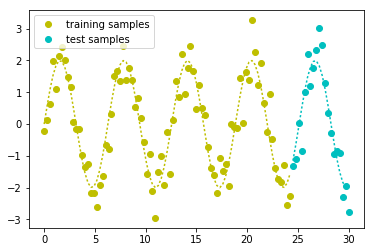

In [1081]:
train_y = y.copy()

noise_factor = 0.5
train_y += np.random.randn(105) * noise_factor

l1, = plt.plot(x[:85], train_y[:85], 'yo', label = 'training samples')
plt.plot(x[:85], y[:85], 'y:')
l2, = plt.plot(x[85:], train_y[85:], 'co', label = 'test samples')
plt.plot(x[85:], y[85:], 'c:')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

## Create function for generating training samples

In [1082]:
input_seq_len = 15
output_seq_len = 20

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x):
    return true_signal(x) + noise_func(x)

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x) for x in input_seq_x]
    output_seq_y = [generate_y_values(x) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)


In [1088]:
input_seq, output_seq = generate_train_samples(batch_size=10)

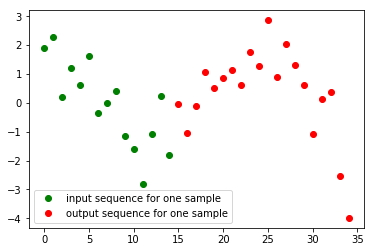

In [1089]:
l1, = plt.plot(range(15), input_seq[1], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[1], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

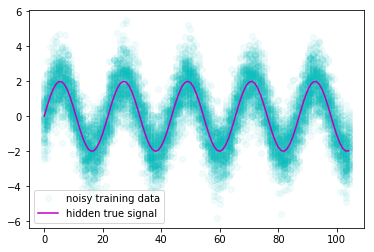

In [1038]:
results = []
for i in range(100):
    temp = generate_y_values(x)
    results.append(temp)
results = np.array(results)

for i in range(100):
    l1, = plt.plot(results[i].reshape(105, -1), 'co', lw = 0.1, alpha = 0.05, label = 'noisy training data')

l2, = plt.plot(true_signal(x), 'm', label = 'hidden true signal')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## basic_rnn_seq2seq

In [1389]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

## Training process

In [968]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('/home/weimin/seq2seq', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

41.1176
15.1229
38.0447
17.5147
10.7143
15.86
11.0018
9.36498
9.34505
7.63867
8.26214
8.62254
7.46555
7.17563
6.67522
7.90181
7.44982
6.85178
6.64263
6.51683
7.43415
7.29108
6.76634
7.29156
5.82366
6.47035
6.90508
6.85749
6.0019
6.28373
6.17705
6.84661
5.80455
5.47456
6.52167
7.24837
5.39331
5.87026
6.03717
5.69669
6.24579
6.59434
6.05836
6.79707
7.07084
7.07718
5.90321
6.3736
6.32405
5.52204
6.04222
6.2319
6.91148
6.90261
5.40284
5.23631
7.13538
6.06989
6.92842
6.06214
5.92808
6.3901
6.6459
5.29751
5.78749
5.04739
6.03459
5.67487
6.06949
5.89078
5.4066
5.47715
6.0871
6.76781
5.77563
5.95955
6.45133
6.43384
5.46838
6.15912
6.21651
5.5001
6.81652
6.0753
6.10818
5.54456
5.30648
5.5362
5.96539
5.4078
6.16993
6.70788
5.74594
5.66448
6.23474
5.99408
6.12859
5.7535
5.7275
6.19146
Checkpoint saved at:  /home/weimin/seq2seq/univariate_ts_model0


## Inference

In [947]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('/home/weimin/seq2seq', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from /home/weimin/seq2seq/univariate_ts_model0


## Plot the last 20 predictions

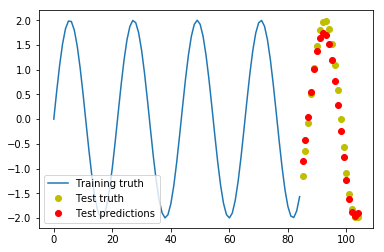

In [948]:
l1, = plt.plot(range(85), true_signal(train_data_x[:85]), label = 'Training truth')
l2, = plt.plot(range(85, 105), y[85:], 'yo', label = 'Test truth')
l3, = plt.plot(range(85, 105), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()

## Multivariate time series: 3-input-2-output

### Input sequences

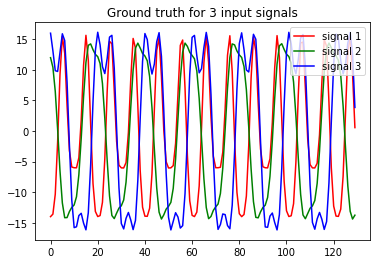

In [1040]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2*x1 + 6*x2 - 6*x1
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Ground truth for 3 input signals")
l1, = plt.plot(y1, 'r', label = 'signal 1')
l2, = plt.plot(y2, 'g', label = 'signal 2')
l3, = plt.plot(y3, 'b', label = 'signal 3')

plt.legend(handles = [l1, l2, l3], loc = 'upper right')

plt.show()

### Both input and output sequences

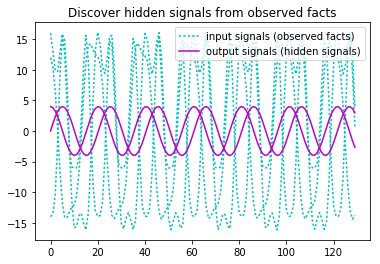

In [1164]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Discover hidden signals from observed facts")
l1, = plt.plot(y1, 'c:', label = 'input signals (observed facts)')
plt.plot(y2, 'c:')
plt.plot(y3, 'c:')

l4, = plt.plot(2 * x1, 'm', label = 'output signals (hidden signals)')
plt.plot(2 * x2, 'm') # multiplies by 2 just for visualization purpose

plt.legend(handles = [l1, l4], loc = 'upper right')

plt.show()

## Create function that generates training samples

In [972]:
input_seq_len = 15
output_seq_len = 20
x = np.linspace(0, 40, 130)
train_data_x = x[:110]

def true_output_signals(x):
    x1 = 2 * np.sin(x)
    x2 = 2 * np.cos(x)
    return x1, x2

def true_input_signals(x):
    x1, x2 = true_output_signals(x)
    y1 = 1.6*x1**4 - 2*x2 - 10
    y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
    y3 = 2*x1**3 + 2*x2**3 - x1*x2
    return y1, y2, y3

def noise_func(x, noise_factor = 2):
    return np.random.randn(len(x)) * noise_factor

def generate_samples_for_output(x):
    x1, x2 = true_output_signals(x)
    return x1+noise_func(x1, 0.5), \
           x2+noise_func(x2, 0.5)

def generate_samples_for_input(x):
    y1, y2, y3 = true_input_signals(x)
    return y1+noise_func(y1, 2), \
           y2+noise_func(y2, 2), \
           y3+noise_func(y3, 2)

def generate_train_samples(x = train_data_x, batch_size = 10):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_samples_for_input(x) for x in input_seq_x]
    output_seq_y = [generate_samples_for_output(x) for x in output_seq_x]
    
    ## return shape: (batch_size, time_steps, feature_dims)
    return np.array(input_seq_y).transpose(0, 2, 1), np.array(output_seq_y).transpose(0, 2, 1)


### Visualize one data sample from training

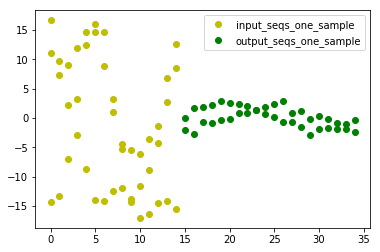

In [1065]:
input_seq, output_seq = generate_train_samples(batch_size=100)

i1, i2, i3= plt.plot(range(input_seq_len), input_seq[0], 'yo', label = 'input_seqs_one_sample')
o1, o2 = plt.plot(range(input_seq_len,(input_seq_len+output_seq_len)), output_seq[0], 'go', label = 'output_seqs_one_sample')
plt.legend(handles = [i1, o1])
plt.show()



## Build the model

In [975]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 3 
# num of output signals
output_dim = 2 
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

## Train the model

In [976]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('/home/weimin/seq2seq', 'multivariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)




Training losses: 
50.4378
29.4938
43.5427
17.5781
13.1901
15.2156
13.6485
9.8989
9.41728
8.24638
8.14999
6.21027
7.12312
6.6372
6.57446
6.78877
6.69754
6.35975
6.22825
6.58693
6.22279
6.48205
6.62082
6.23881
6.43474
6.15408
5.8705
6.25665
6.0838
6.4018
6.38748
5.89008
5.90011
5.06541
6.34175
5.8847
5.75557
6.29616
5.73591
6.49518
6.14976
5.6607
6.32643
5.57528
5.88868
5.96276
6.39109
6.28839
5.75509
6.22248
5.68736
5.59833
5.46714
5.87019
5.58199
6.25759
5.5679
5.97546
5.95305
5.72757
6.68685
5.54343
6.36072
5.58917
6.3271
5.84201
6.05612
5.94092
5.53338
5.9553
5.56964
5.76427
5.93115
5.45271
5.19912
5.90918
5.71393
5.27911
5.51282
5.66456
5.15903
5.57481
6.49853
5.91504
5.87254
5.79153
5.67229
5.89012
5.27889
5.56796
5.14666
5.00124
5.43739
5.88099
5.76084
5.582
4.97639
5.55082
5.2532
6.17312
Checkpoint saved at:  /home/weimin/seq2seq/multivariate_ts_model0


## Inference

In [1157]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('/home/weimin/seq2seq', 'multivariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1, -1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 0)
    
    

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f70fc9c8840>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.6/weakref.py", line 327, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


INFO:tensorflow:Restoring parameters from /home/weimin/seq2seq/multivariate_ts_model0


In [1159]:
final_preds.shape

(20, 2)

## Visualize predictions over true signals 

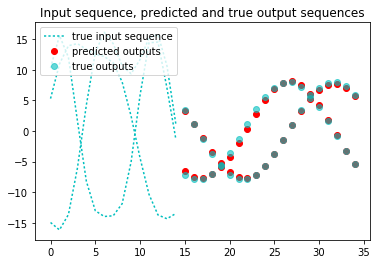

In [1074]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Input sequence, predicted and true output sequences")
i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), 4 * final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), 4 * np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', alpha = 0.6, label = 'true outputs')
plt.legend(handles = [i1, p1, t1], loc = 'upper left')
plt.show()



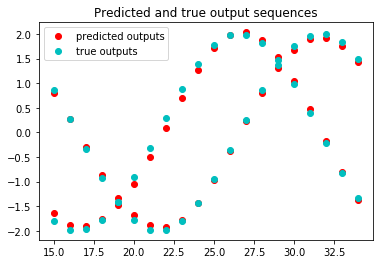

In [981]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Predicted and true output sequences")
#i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', label = 'true outputs')
plt.legend(handles = [p1, t1], loc = 'upper left')
plt.show()

## Extreme events

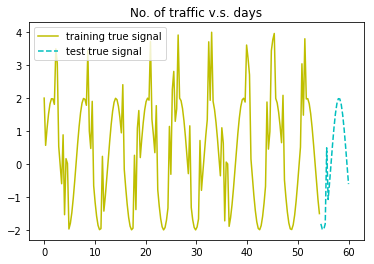

In [1390]:
x = np.linspace(0, 60, 210)
y = 2 * np.sin(x)
num_events_train = 40
num_events_test = 1
extreme_factor = 2
np.random.seed(10)
train_events_x = np.random.choice(range(190), num_events_train)
test_events_x = np.random.choice(range(190, 210), num_events_test)
y[train_events_x] += extreme_factor
y[test_events_x] += extreme_factor

plt.title('No. of traffic v.s. days')

l1, = plt.plot(x[:190], y[:190], 'y', label = 'training true signal')
l2, = plt.plot(x[190:], y[190:], 'c--', label = 'test true signal')

plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

In [1404]:
input_seq_len = 15
output_seq_len = 20
extreme_factor = 2 # 2 additional units of traffic increase if extreme / outlier

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

np.random.seed(10)
num_events_train = 40 # total number of extreme events in training data
train_events_bool = np.zeros(190)
train_events_x = np.random.choice(range(190), num_events_train)
train_events_bool[train_events_x] = 1

num_events_test = 1 # total number of extreme events in test data 
test_events_bool = np.zeros(20)
test_events_x = np.random.choice(range(20), num_events_test)
test_events_bool[test_events_x] = 1.
                    
def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x, event_bool):
    return true_signal(x) + noise_func(x) + extreme_factor * event_bool

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len, train_events_bool = train_events_bool):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    input_seq_event_bool = [train_events_bool[i:(i+input_seq_len)] for i in start_x_idx]
    
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    output_seq_event_bool = [train_events_bool[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(input_seq_x, input_seq_event_bool)]
    output_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(output_seq_x, output_seq_event_bool)]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y), np.array(input_seq_event_bool), np.array(output_seq_event_bool)

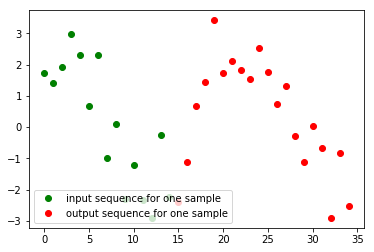

In [1405]:
input_seq, output_seq, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=10)
l1, = plt.plot(range(15), input_seq[0], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[0], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## Build and train

In [1406]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 


In [1408]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('/home/weimin/seq2seq', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

72.4648
72.2901
50.532
57.4347
38.9367
42.1026
39.7015
39.4057
32.1673
35.8084
38.0234
36.8531
36.5649
38.4891
41.6419
40.6267
37.9046
36.5633
42.1841
36.9672
34.2346
35.3739
37.1375
30.8412
34.6888
37.767
29.7319
35.9878
41.6386
31.2345
31.9563
35.5043
37.4713
31.9136
34.0474
35.982
35.7627
32.9174
37.166
34.3574
32.0194
31.6907
31.3649
33.7653
35.9163
32.4492
37.2708
30.2752
35.7085
34.564
35.6234
37.1721
33.5075
32.4043
33.0276
41.9962
35.8538
33.8398
34.4645
37.7238
42.3043
38.6089
31.9182
32.0321
34.66
36.259
38.5098
34.9654
39.3925
39.2959
38.1631
34.6078
33.7109
34.9411
41.2333
32.6717
36.8063
31.1065
33.8314
36.5651
35.6191
33.9258
32.079
33.3361
32.071
34.7764
35.3483
33.0749
32.5485
35.0106
32.9155
35.28
34.2658
37.0338
35.2134
34.7827
32.3402
35.6996
35.986
33.4069
32.4724
33.5742
35.5572
32.9599
39.3558
34.1684
32.3334
36.4917
36.5461
31.5706
36.0554
37.2879
37.5641
36.1052
32.692
34.7269
36.6045
32.645
27.3694
39.4354
31.9742
33.3369
31.2183
35.3707
33.4366
33.7334
36.205


## Inference

In [1409]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('/home/weimin/seq2seq', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from /home/weimin/seq2seq/univariate_ts_model0


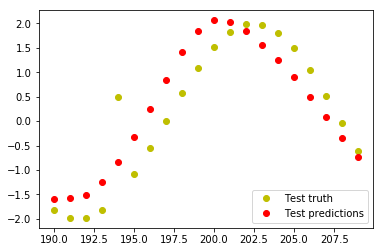

In [1410]:
#l1, = plt.plot(range(190), true_signal(train_data_x[:190]), label = 'Training truth')
l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()

## Build extreme events seq2seq model

In [1367]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.contrib.layers.xavier_initializer()),

        'out_dec_inp': tf.get_variable('Weights_out_dec', \
                               shape = [output_dim+1, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.contrib.layers.xavier_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.zeros_initializer()),

        'out_dec_inp': tf.get_variable('Biases_out_dec', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.zeros_initializer()),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Extreme events bool vectors for input
        #input_seq_extremes_bool = [
        #    tf.placeholder(tf.float32, shape=(None, 1), name="event_bool".format(t))
        #      for t in range(input_seq_len)
        #]

        # Extreme events bool vectors for output
        output_seq_extremes_bool = [
            tf.placeholder(tf.float32, shape=(None, 1), name="event_bool".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]
        dec_inp = [ tf.concat([b, d], 1) for b, d in zip(output_seq_extremes_bool, dec_inp) ]

        #enc_inp = [ tf.concat([b, e], 1) for b, e in zip(input_seq_extremes_bool, enc_inp_raw) ]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              else:
                inp = tf.matmul(inp, weights['out_dec_inp']) + biases['out_dec_inp']
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, i):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          #return tf.matmul(prev, weights['out']) + biases['out']
          temp_out = tf.matmul(prev, weights['out']) + biases['out']
          temp_concat = tf.concat([output_seq_extremes_bool[i], temp_out], 1)
          return tf.matmul(temp_concat, weights['out_dec_inp']) + biases['out_dec_inp']

        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        output_seq_extremes_bool = output_seq_extremes_bool, 
        )

In [1371]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, batch_in_event_bool, batch_out_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        #feed_dict.update({rnn_model['input_seq_extremes_bool'][t]: batch_in_event_bool[:,t].reshape(-1,1) for t in range(input_seq_len)})
        feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: batch_out_event_bool[:,t].reshape(-1,1) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('/home/weimin/seq2seq', 'univariate_ts_model_eventsBool'))
        
print("Checkpoint saved at: ", save_path)

75.2204
70.2368
50.8854
38.3603
53.3303
43.9528
35.9993
48.5663
45.8062
43.7632
48.0552
41.9545
37.6495
37.793
38.708
36.8824
34.2794
40.5688
32.9628
34.6932
35.6213
36.5696
32.6683
42.0376
42.181
36.0932
38.4754
36.7201
39.987
36.4207
37.7422
30.9576
37.7225
32.7419
39.2975
41.0699
28.9323
37.2943
30.2964
37.8868
31.5023
38.4734
40.751
35.5683
33.807
32.7871
37.1364
34.1385
38.8494
35.4937
30.9656
40.5879
37.7389
39.2688
34.7494
37.2397
31.7654
37.5602
37.9008
33.9018
38.5711
35.173
34.166
35.8337
33.9564
31.7259
35.2886
33.5368
30.5252
41.6389
43.671
31.9151
36.8083
37.054
31.8673
32.5654
35.2943
34.5016
34.7038
36.5677
34.9643
31.7971
35.3845
31.7853
33.9145
31.4722
40.6495
32.0913
31.5486
38.3856
42.3331
33.3422
36.2511
35.6261
33.1163
35.1164
31.9043
34.1578
33.2974
32.0841
39.1189
35.1319
34.6166
42.599
36.573
36.5078
40.1942
35.6998
32.1112
34.5099
36.2608
34.7955
33.966
34.2096
34.1786
39.1095
39.9093
34.9721
31.2233
33.0348
33.6123
32.4196
35.2871
31.7354
32.8619
37.7599
41.52

## Inference

In [1387]:
test_seq_input = true_signal(train_data_x[-15:])
test_events_bool_input = train_events_bool[-15:]
test_events_bool_output = test_events_bool.copy()

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('/home/weimin/seq2seq', 'univariate_ts_model_eventsBool'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, 1]) for t in range(output_seq_len)})
    feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: test_events_bool_output[t].reshape(1,1) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    

INFO:tensorflow:Restoring parameters from /home/weimin/seq2seq/univariate_ts_model_eventsBool


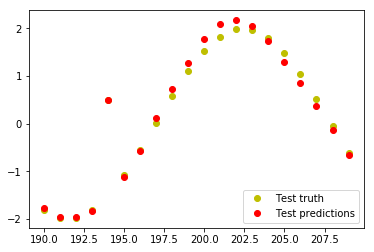

In [1388]:
final_preds  = np.array(final_preds).reshape(-1)

l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()